# Checking the modularization of software systems by analyzing co-changing source code files

Presentation version

## The System under Investigation

## DropOver

![](resources/dropover_package_structure.png)


## Idea


## Data
Each commit and their changed file

### Reading in the data

In [4]:
from lib.ozapfdis.git_tc import log_numstat

GIT_REPO_DIR = "../../dropover_git/"
git_log = log_numstat(GIT_REPO_DIR)[['sha', 'file']]
git_log.head()

,sha,file
1,8c686954,backend/pom-2016-07-16_04-40-56-752.xml
4,97c6ef96,backend/src/test/java/at/dropover/scheduling/i...
6,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/js...
7,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/vi...
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...


### Filtering out non-production code

In [5]:
prod_code = git_log.copy()
prod_code = prod_code[prod_code.file.str.endswith(".java")]
prod_code = prod_code[prod_code.file.str.startswith("backend/src/main")]
prod_code = prod_code[~prod_code.file.str.endswith("package-info.java")]
prod_code.head()

,sha,file
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...


# Analysis

We want to see which files are changing (almost) together. A good start for this is to create this view onto our dataset with the `pivot_table` method of the underlying pandas' DataFrame. 

But before this, we need a marker column that signals that a commit occurred. We can create an additional column named `hit` for this easily.

In [6]:
prod_code['hit'] = 1
prod_code.head()

,sha,file,hit
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...,1
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...,1
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...,1
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...,1
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...,1


Now, we can transform the data as we need it: For the index, we choose the filename, as columns, we choose the unique `sha` key of a commit. Together with the commit hits as values, we are now able to see which file changes occurred in which commit. Note that the pivoting also change the order of both indexes. They are now sorted alphabetically.

In [7]:
commit_matrix = prod_code.reset_index().pivot_table(
    index='file',
    columns='sha',
    values='hit',
    fill_value=0)
commit_matrix.iloc[0:5,50:55]

sha,3597d8a2,3b70ea7e,3d3be4ca,3e4ae692,429b3b32
file,,,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0,0,0,0,0


As already [mentioned in a previous blog post](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/#Analysis), we are now able to look at our problem from a mathematician' s perspective. What we have here now with the `commit_matrix` is a collection of  n-dimensional vectors. Each vector represents a filename and the components/dimensions of such a vector are the commits with either the value 0 or 1. 

Calculating similarities between such vectors is a well-known problem with a variety of solutions. In our case, we calculate the distance between the various vectors with the cosines distance metric. The machine learning library scikit-learn provides us with [an easy to use implementation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).

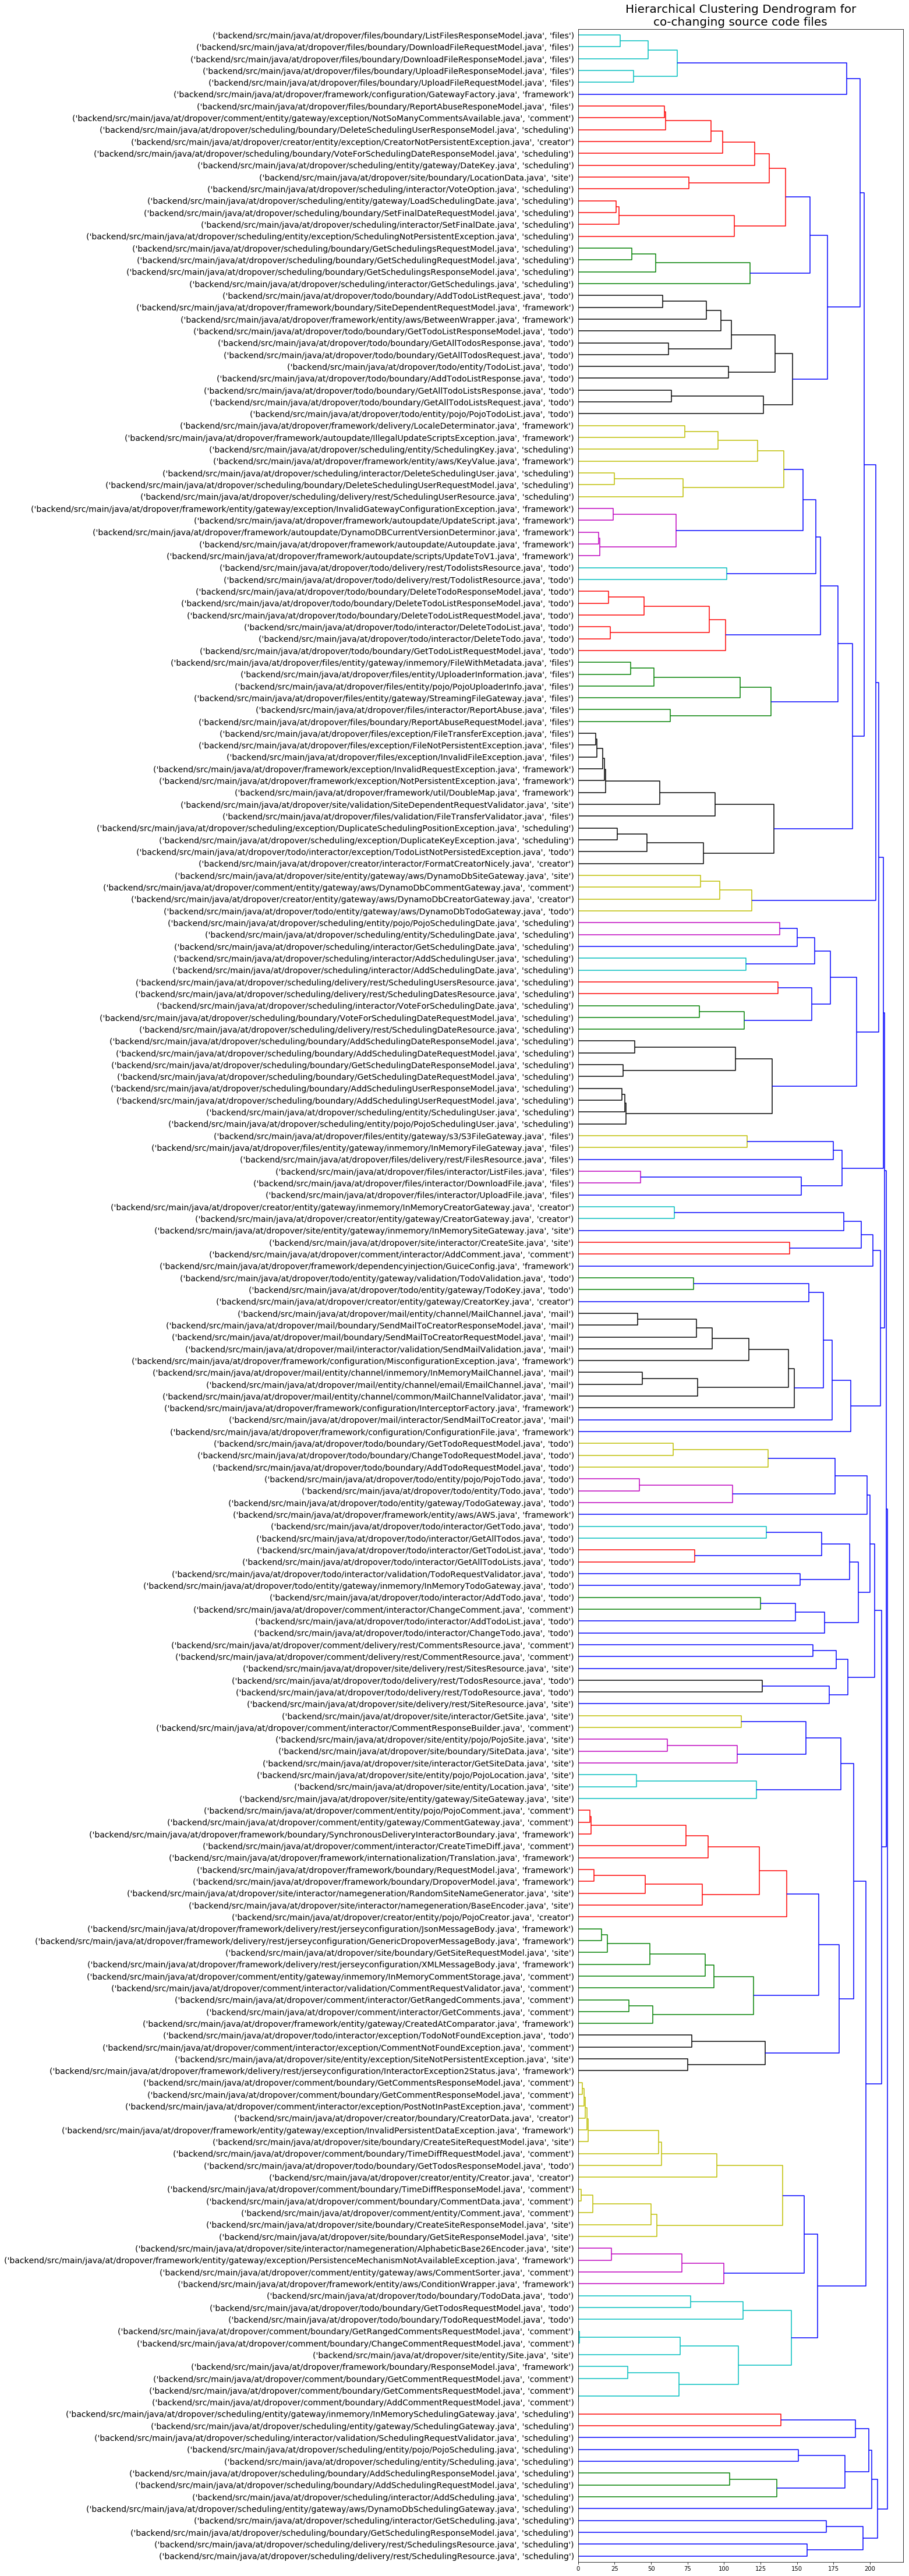

In [9]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack(
        [children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', leaf_font_size=14, **kwargs)


X= commit_matrix
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(X)
plt.figure(figsize=(10,80))
modules = commit_matrix.index.str.split("/").str[6]
plt.title('Hierarchical Clustering Dendrogram for\nco-changing source code files', size="20")
plot_dendrogram(model, labels=tuple(zip(X.index, modules)))
plt.savefig('test.png', bbox_inches='tight')
plt.show()


In [10]:
from sklearn.metrics.pairwise import cosine_distances

dissimilarity_matrix = cosine_distances(commit_matrix)
dissimilarity_matrix[:5,:5]

array([[ 0.        ,  0.29289322,  0.5       ,  0.18350342,  0.29289322],
       [ 0.29289322,  0.        ,  0.29289322,  0.1339746 ,  0.5       ],
       [ 0.5       ,  0.29289322,  0.        ,  0.59175171,  0.29289322],
       [ 0.18350342,  0.1339746 ,  0.59175171,  0.        ,  0.42264973],
       [ 0.29289322,  0.5       ,  0.29289322,  0.42264973,  0.        ]])

In [27]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = principalDf.copy()
finalDf['module'] = modules
finalDf.head()

,principal component 1,principal component 2,module
0,-0.294463,-0.584800,comment
1,-0.775555,-0.398396,comment
2,-0.321314,-0.531619,comment
3,-0.683570,-0.385591,comment
4,-0.229329,-0.518814,comment


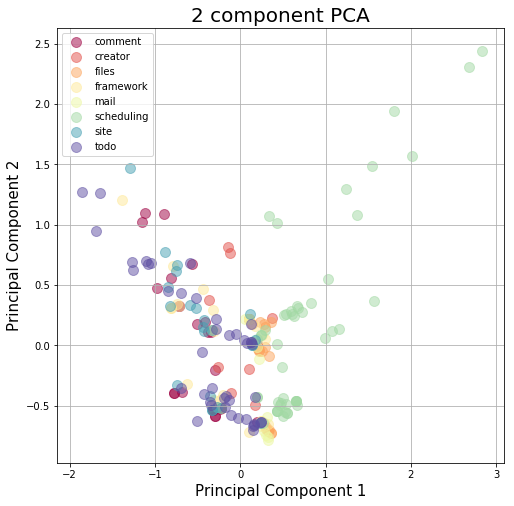

In [35]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

   
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = finalDf['module'].unique()
colors = [x for x in cm.Spectral(np.linspace(0,1,len(targets)))]

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['module'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 100
               , alpha=0.5)
    
ax.legend(targets)
ax.grid()


In [41]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
xTrue = np.linspace(0, 1000, N)
yTrue = 3 * xTrue
xData = xTrue + np.random.normal(0, 100, N)
yData = yTrue + np.random.normal(0, 100, N)
xData = np.reshape(xData, (N, 1))
yData = np.reshape(yData, (N, 1))
data = np.hstack((xData, yData))
data.shape

(1000, 2)

[[-0.31222815 -0.95000715]
 [-0.95000715  0.31222815]]


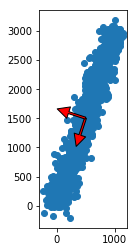

In [39]:
mu = data.mean(axis=0)
data = data - mu
# data = (data - mu)/data.std(axis=0)  # Uncommenting this reproduces mlab.PCA results
eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
projected_data = np.dot(data, eigenvectors)
sigma = projected_data.std(axis=0).mean()
print(eigenvectors)

fig, ax = plt.subplots()
ax.scatter(xData, yData)
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax.annotate(
        '', xy=end, xycoords='data',
        xytext=start, textcoords='data',
        arrowprops=dict(facecolor='red', width=2.0))
ax.set_aspect('equal')
plt.show()

In [47]:
xData = finalDf['principal component 1'].values
yData = finalDf['principal component 2'].values
data = np.stack((xData, yData)).T
data.shape

(214, 2)

[[ -1.00000000e+00   4.41673359e-16]
 [  4.41673359e-16   1.00000000e+00]]


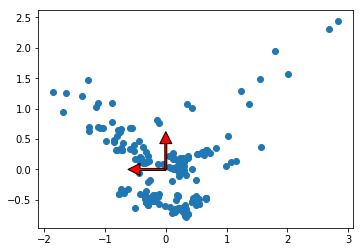

In [48]:
mu = data.mean(axis=0)
data = data - mu
# data = (data - mu)/data.std(axis=0)  # Uncommenting this reproduces mlab.PCA results
eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
projected_data = np.dot(data, eigenvectors)
sigma = projected_data.std(axis=0).mean()
print(eigenvectors)

fig, ax = plt.subplots()
ax.scatter(xData, yData)
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax.annotate(
        '', xy=end, xycoords='data',
        xytext=start, textcoords='data',
        arrowprops=dict(facecolor='red', width=2.0))
ax.set_aspect('equal')
plt.show()

In [ ]:
plot_data = pd.DataFrame(index=finalDf['module'])
plot_data['value'] = tuple(zip(
    finalDf['principal component 1'],
    finalDf['principal component 2']))
plot_data['label'] = commit_matrix.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

In [ ]:
import pygal

xy_chart = pygal.XY(stroke=False)
[xy_chart.add(entry[0], entry[1]) for entry in plot_dict.iteritems()]   
# uncomment to create the interactive chart
xy_chart.render_in_browser()
xy_chart

To be able to better understand the result, we add the file names from the `commit_matrix` as index and column index  to the `dissimilarity_matrix`.

In [ ]:
import pandas as pd
dissimilarity_df = pd.DataFrame(
    dissimilarity_matrix,
    index=commit_matrix.index,
    columns=commit_matrix.index)
dissimilarity_df.iloc[:5,:2]

Now, we see the result in a better representation: For each file pair, we get the distance of the commit vectors. This means that we have now a distance measure that says how dissimilar two files were changed in respect to each other.

# Visualization

## Heatmap
To get an overview of the result's data, we can plot the matrix with a little heatmap first.

In [ ]:
%matplotlib inline
import seaborn as sns

sns.heatmap(
    dissimilarity_df,
    xticklabels=False,
    yticklabels=False
);

Because of the alphabetically ordered filenames and the "feature-first" architecture of the  software under investigation, we get the first glimpse of how changes within modules are occurring together and which are not.

To get an even better view, we can first extract the module's names with an easy string operation and use this for the indexes.

In [ ]:
modules = dissimilarity_df.copy()
modules.index = modules.index.str.split("/").str[6]
modules.index.name = 'module'
modules.columns = modules.index
modules.iloc[25:30,25:30]

Then, we can create another heatmap that shows the name of the modules on both axes for further evaluation. We also just take a look at a subset of the data for representational reasons.

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,9])
sns.heatmap(modules.iloc[:180,:180]);

### Discussion

* Starting at the upper left, we see the "comment" module with a pretty dark area very clearly. This means, that files around this module changed together very often.
* If we go to the middle left, we see dark areas between the "comment" module and the "framework" module as well as the "site" module further down. This shows a change dependency between the "comment" module and the other two (I'll explain later, why it is that way).
* If we take a look in the middle of the heatmap, we see that the very dark area represents changes of the "mail" module. This module was pretty much changed without touching any other modules. This shows a nice [separation of concerns](https://en.wikipedia.org/wiki/Separation_of_concerns).
* For the "scheduling" module, we can also see that the changes occurred mostly cohesive within the module.
* Another interesting aspect is the horizontal line within the "comment" region: These files were changed independently from all other files within the module. These files were the code for an additional data storage technology that was added in later versions of the software system. This pattern repeats for all other modules more or less strongly.

With this visualization, we can get a first impression of how good our software architecture fits the real software development activities. In this case, I would say that you can see most clearly that the source code of the modules changed mostly within the module boundaries. But we have to take a look at the changes that occur in other modules as well when changing a particular module. These could be signs of unwanted dependencies and may lead us to an architectural problem.

## Multi-dimensional Scaling
We can create another kind of visualization to check 
* if the code within the modules is only changed altogether and
* if not, what other modules were changed.

Here, we can help ourselves with a technique called ["multi-dimensional scaling"](https://en.wikipedia.org/wiki/Multidimensional_scaling) or "MDS" for short. With MDS, we can break down an n-dimensional space to a lower-dimensional space representation. MDS tries to keep the distance proportions of the higher-dimensional space when breaking it down to a lower-dimensional space.

In our case, we can let MDS figure out a 2D representation of our dissimilarity matrix (which is, overall, just a plain multi-dimensional vector space) to see which files get change together. With this, we'll able to see which files are changes together regardless of the modules they belong to.

The machine learning library scikit-learn gives us easy access to [the algorithm that we need for this task](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html) as well. We just need to say that we have a precomputed dissimilarity matrix when initializing the algorithm and then pass our `dissimilarity_df` DataFrame to the `fit_transform` method of the algorithm.

In [ ]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=0)
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

The result is a 2D matrix that we can plot with `matplotlib` to get a first glimpse of the distribution of the calculated distances.

In [ ]:
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
plt.scatter(x, y);

With the plot above, we see that the 2D transformation somehow worked. But we can't see
* which filenames are which data points
* how the modules are grouped all together

So we need to enrich the data a little bit more and search for a better, interactive visualization technique.

Let's add the filenames to the matrix as well as nice column names. We, again, add the information about the module of a source code file to the DataFrame.

In [ ]:
dissimilarity_2d_df = pd.DataFrame(
    dissimilarity_2d,
    index=commit_matrix.index,
    columns=["x", "y"])
dissimilarity_2d_df['module'] = dissimilarity_2d_df.index.str.split("/").str[6]
dissimilarity_2d_df.head()

OK, here comes the ugly part: We have to transform all the data to the format our interactive visualization library pygal needs for its [XY chart](http://www.pygal.org/en/stable/documentation/types/xy.html). We need to 
* group the data my modules
* add every distance information 
 * for each file as well as
 * the filename itself  
 
in a specific dictionary-like data structure.

But there is nothing that can hinder us in Python and pandas. So let's do this!

1. We create a separate DataFrame named `plot_data` with the module names as index
1. We join the coordinates `x` and `y` into a tuple data structure
1. We use the filenames from `dissimilarity_2d_df`'s index as labels
1. We convert both data items to a dictionary
1. We append each entry for a module to only on module entry

This gives us a new DataFrame with modules as index and per module a list of dictionary-like entries with 
* the filenames as labels and
* the coordinates as values.

In [ ]:
plot_data = pd.DataFrame(index=dissimilarity_2d_df['module'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df['x'], dissimilarity_2d_df['y']))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

With this nice little data structure, we can fill pygal's XY chart and create [an interactive chart](https://feststelltaste.github.io/software-analytics/notebooks/vis/checking_modularization/dropover.html).

In [ ]:
import pygal

xy_chart = pygal.XY(stroke=False)
[xy_chart.add(entry[0], entry[1]) for entry in plot_dict.iteritems()]   
# uncomment to create the interactive chart
xy_chart.render_in_browser()
xy_chart

This view is a pretty cool way for checking the real change behavior of your software including an architectural perspective. 

### Example
Below, you see the complete data for a data point if you hover over that point:

![](resources/cm_example.png)

You can see the following here:
* In the upper left, you find the name of the module in the gray color
* You find the complete name of the source code file in the middle
* You can see the coordinates that MDS assigned to this data point in the color of the selected module

Let's dive even deeper into the chart to get some insights that we can gain from our result.

### Discussion

#### Module "mail"

![](resources/cm_mail.png)

As already seen in the heatmap, we can see that all files of the "mail" module are very close together. This means that the files changed together very often. 

*In the XY chart, we can see this clearly when we hover over the "mail" entry in the legend on the upper left. The corresponding data points will be magnified a little bit.*

#### Module "scheduling"

![](resources/cm_scheduling.png)

Another interesting result can be found if we take a look at the distribution of the files of the module "scheduling". Especially the data points in the lower region of the chart indicate clearly that these files were changed almost exclusive together.

*In the XY chart, we can take a look at the relevant data points by selecting just the "scheduling" data points by deselecting all the other entries in the legend.*

#### Modules "comment", "framework" and "site"

![](resources/cm_comment.png)

The last thing I want to show you in our example is the common change pattern for the files of the modules "comment", "framework" and "site". The files of these modules changed together very often, leading to a very mixed colored region in the upper middle. In case of our system under investigation, this is perfectly explainable: These three modules were developed at the beginning of the project. Due to many redesigns and refactorings, those files had to be changed all together. For these modules, it would make sense to only look at the recent development activities to find out if the code within these modules is still co-changing.

*In the XY chart, just select the modules "comment", "framework" and "site" to see the details.*

# Summary
We've seen how you can check the modularization of your software system by also taking a look at the development activities that is stored in the version control system. This gives you plenty of hints if you've chosen a software architecture that also fits the commit behavior of your development teams.

But there is more that we could add here: You cannot only check for modularization. You could also e. g. take a look at the commits of your teams, spotting parts that are getting changed from too many teams. You could also see if your actions taken had any effect by checking only the recent history of the commits. You can also redefine what co-changing means e. g. you define it as files that were changed on the same day, which would kind of  balance out different commit styles of different developers.

But for now, we are leaving it here. You can experiment with further options on your own. You can find [the complete Jupyter notebook on GitHub](https://github.com/feststelltaste/software-analytics/blob/master/notebooks/Checking%20the%20modularization%20of%20software%20systems%20by%20analyzing%20co-changing%20source%20code%20files.ipynb).